<a id='top'></a>
# NIRSpec IFU Pipeline Processing ERO 02732 NGC 7319 AGN
<hr style="border:3px solid black">

## Table of Contents

* [1. Introduction](#intro)
* [2. Import Library](#imports)
* [3. Convenience Functions](#func)
* [4. Directory Set-Up](#dir_setup)
* [5. Download the data](#data)
* [6. Products Found In MAST](#mast_products)
  * [6.1 Stage 1 Products Found In MAST](#level1_mast)
  * [6.2 Stage 2 Products Found In MAST](#level2_mast)
  * [6.3 Stage 3 Products Found In MAST](#level3_mast)
* [7. Re-processing the Data](#reprocessing)
  * [7.1 Stage 1 Rerun & Products](#level1_rerun)
  * [7.2 Stage 2 Rerun & Products](#level2_rerun)
  * [7.3 Stage 3 Rerun & Products](#level3_rerun)
    * [7.3.1 New Outlier Detection Algorithm](#outlier_detection_new)
* [Conclusion](#conclusion)
* [About This Notebook](#about)



## 1. Introduction <a id='intro'></a>
<hr style="border:1px solid gray">

End-to-end calibration of JWST data is divided into 3 main stages of processing. This notebook explores how to run the JWST calibration pipeline stages 1-3 for NIRSpec IFU spectroscopic data.
   <figure>
       <img src='./NGC_7319_AGN.png' title="Figure 1: NGC 7319 AGN" alt="NGC_7319_AGN" class="bg-primary" align="right" style="width: 400px; height: 350px;"/>
   </figure>

>* **`STAGE 1`** ([calwebb_detector1](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1)): consists of detector-level corrections, performed on a group-by-group basis, followed by ramp fitting.
    * **Input**: Raw exposure (`uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
    * **Output**: Corrected countrate (slope) image (`rate.fits`) 
>* **`STAGE 2`** ([calwebb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)): consists of additional instrument-level and observing mode corrections and calibrations.
    * **Input**: A single corrected countrate (slope) image (`rate.fits`) or an ASN file listing multiple inputs.
    * **Output**: A fully calibrated unrectified exposure (`cal.fits`). For NIRSpec IFU data, the `cube_build` step returns a 3-D IFU spectroscopic cube (`s3d.fits`). The `extract_1d` step  returns 1-D extracted spectral data products (`x1d.fits`)
>* **`STAGE 3`** ([calwebb_spec3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html#calwebb-spec3)): consists of additional corrections (e.g. `outlier_detection`) and routines for combining calibrated data from multiple exposures (e.g. dither/nod pattern) into a single combined 2-D or 3-D spectral product and a combined 1-D spectrum. 
    * **Input**: An ASN file that lists multiple calibrated exposures (`cal.fits`).
    * **Output**: For NIRSpec IFU data, a resampled and combined 3-D IFU cube (`s3d.fits`) and a 1-D extracted spectrum (`x1d.fits`)

Here, we will focus on the mechanics of processing "real" example data [(NGC 7319 AGN)](#NGC_7319_AGN) from Early Release Science (ERS) Proposal ID 2732, including how to use associations for multi-exposure combination, how to interact and work with data models for each product, and mainly how to process IFU data as an extended source. Our objective is to examine the automated products found in MAST and compare them to products generated with the most up-to-date version of the JWST calibration pipeline.

Most processing runs shown here use the default reference files from the Calibration Reference Data System (CRDS). Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if using a subsequent version. There are also a few known issues with some of the pipeline steps in this build that we expect to be fixed in the near future. Until then, at various steps, we provide users with the current processing recommendations when running the pipeline manually.

## 2. Import Library <a id='imports'></a>
<hr style="border:1px solid gray">

In [1]:
#Import Library

#--------------------------------------JWST Calibration Pipeline Imports-------------------------------------------

import jwst
import crds
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   #calwebb_detector1
from jwst.pipeline import Spec2Pipeline       #calwebb_spec2
from jwst.pipeline import Spec3Pipeline       #calwebb_spec3
from jwst.extract_1d import Extract1dStep     #Extract1D Individual Step

print("JWST Calibration Pipeline Version={}".format(jwst.__version__))
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))

#----------------------------------------------General Imports-----------------------------------------------------

import numpy as np
import warnings
warnings.filterwarnings('ignore') #Set to 'default' to turn warnings back on

#--------------------------------------------File Operation Imports------------------------------------------------

import glob
import os
import asdf
import json
from shutil import copy

#--------------------------------------------Astropy/Astroquery Imports--------------------------------------------

from astropy.io import fits
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch, AsinhStretch, SqrtStretch
from astropy.stats import sigma_clipped_stats
import astroquery
from astroquery.mast import Mast
from astroquery.mast import Observations

#------------------------------------------------Plotting Imports--------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as grd
from matplotlib.patches import Circle
from matplotlib import cm

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline
# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
plt.rcParams.update({'font.size': 18})

JWST Calibration Pipeline Version=1.11.3
Current Operational CRDS Context = jwst_1118.pmap


## 3. Convenience Functions <a id='func'></a>
<hr style="border:1px solid gray">

In [2]:
def show_image(data_2d, vmin, vmax, xsize=15, ysize=15, title=None, zoom_in=None, aspect=1, scale='log', units='DN/s', cmap='jet'):
    """
    Function to generate a 2-D, log-scaled image of the data
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        2-D image to be displayed
    vmin : float
        Minimum signal value to use for scaling
    vmax : float
        Maximum signal value to use for scaling
    xsize, ysize: int
        Figure Size
    title : str
        String to use for the plot title
    zoom_in: list 
        Zoomed in Region of interest [xstart,xstop,ystart,ystop]
    aspect: int
        Aspect ratio of the axes
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear' or 'Asinh'
    units : str
        Units of the data. Used for the annotation in the color bar. Defualt is DN/s for countrate images
    cmap: str
        Color Map for plot
    """
    #-----------------------------------------Scaling Information----------------------------------------
    
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    elif scale == 'Asinh':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=AsinhStretch())
    
    #--------------------------------------------Set Up Figure-------------------------------------------

    fig = plt.figure(figsize=(xsize, ysize))
    ax = fig.add_subplot(1, 1, 1)
    
    im = ax.imshow(data_2d, origin='lower', norm=norm, aspect=aspect, cmap=cmap)

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    if title:
        plt.title(title)
    
    #Zoom in on a portion of the image? 
    if zoom_in:
        #inset axis 
        axins = ax.inset_axes([0.5, 0.6, 0.5, 0.3])
        
        axins.imshow(data_2d, origin="lower", norm=norm, aspect=aspect, cmap=cmap)
        
        # subregion of the original image
        axins.set_xlim(zoom_in[0], zoom_in[1])
        axins.set_ylim(zoom_in[2], zoom_in[3])
        axins.set_xticklabels([])
        axins.set_yticklabels([])
        ax.indicate_inset_zoom(axins, color="black",edgecolor="black", linewidth=3)

In [3]:
def show_ifu_cubeslices(s3d_file_list, wavelength_slices=[], spaxel_locs=[], y_scale=None, cmap='jet', vmin_vmax = [[[0,15e1]]], save_figure=False, title=None, title_font = 30):
    """
    Function to that takes a 3-D IFU data cube and generates: 
    
    > 2-D cube slices based on wavelength (microns)
    > Associated 1-D spectrum for a designated spaxel (spatial pixel) in the data cube
    > Corresponding 3-D weight image giving the relative weights of the output spaxels
    
    Note: This function can accomidate multiple detectors plotted side-by-side. 
    The general format would follow [[detector 1 info], [detector 2 info]].

    Parameters
    ----------
    s3d_file_list: list of str
        3-D IFU data cube fits file list 
    wavelength_slices: tuple
        List of wavelength values (microns) at which to create 2-D slices. 
    spaxel_locs: tuple
        List of spaxel locations in which to plot the associated 1-D spectrum. (One spaxel location per slice)
    y_scale: tuple
        Y-axis limits for the associated 1-D spectrum of the spaxel. Default is to use the ymin and ymax of the data. 
    cmap: str
        Color Map 
    vmin_vmax: tuple
        Minimum & Maximum signal value to use for scaling (e.g., [[[vmin,vmax],[vmin,vmax]], [[vmin,vmax], [vmin,vmax]]])
    title: str
        Figure Title. Default is None. 
    title_font:int
        Title Font Size
    save_figure: bool
        Save figure?         
    """
    
    #---------------------------------------------- Set-up Figure -------------------------------------------------

    #Plot Slices From the Cube
    fig, axs = plt.subplots(3, np.array(wavelength_slices).size, figsize=(8*np.array(wavelength_slices).size,18))
    gs = grd.GridSpec(3, np.array(wavelength_slices).size, height_ratios=[1]*3, width_ratios=[1]*np.array(wavelength_slices).size, hspace=0.4,wspace=0.7)

    total_num_plots=3*np.array(wavelength_slices).size
    
    plot_count = 0
    #---------------------------------------------Open Files------------------------------------------------------
    
    for s3d_file in s3d_file_list:
        
        root=s3d_file[:-9] #Root file name 

        s3d = fits.open(s3d_file) #3-D IFU data cube fits file 
        x1d3 = datamodels.open(root+'_x1d.fits') #1-D Extracted Spectrum            
    
        #--------------------------------Wavelength & Surface Brightness/Flux Arrays------------------------------
    
        x1d3wave = x1d3.spec[0].spec_table.WAVELENGTH
            
        #--------------------------------------Data & Header Information------------------------------------------

    
        #SCI Extension: [Type:ImageHDU  Cards:92   Dimensions:(57, 61, 973)   Format:float32]
        cube = s3d[1].data #Science data
        wcs = WCS(s3d[1].header) #World Coordinate System (WCS) Transformation keywords 
        wmap = s3d[4].data #3-D weight image giving the relative weights of the output spaxels.
        cdelt1 = s3d[1].header['CDELT1']*3600. #Axis 1 coordinate increment at reference point 
        cdelt2 = s3d[1].header['CDELT2']*3600. #Axis 2 coordinate increment at reference point 
        cdelt3 = s3d[1].header['CDELT3'] #Axis 3 coordinate increment at reference point 
        crval3 = s3d[1].header['CRVAL3'] #third axis value at the reference pixel  

        #Wavelength range of the grating/filter combination
        wavstart = s3d[1].header['WAVSTART']
        wavend = s3d[1].header['WAVEND']
                
        s3d.close()
    
        #---------------------------------------------------Plots-------------------------------------------------
        
        cmap_custom = cm.colors.LinearSegmentedColormap.from_list("", ["darkred","darkturquoise","blue"])
        colors = cmap_custom(np.linspace(0, 1, np.array(wavelength_slices).size))

        #To Account for if NRS1 & NRS2 are both being plotted Side-by-side
        if len(wavelength_slices) != 1:
            if 'nrs1' in s3d_file:
                wavelengths = wavelength_slices[0]
                spaxel_loc = spaxel_locs[0]
                vmin_vmax_vals = vmin_vmax[0]
                
                if y_scale:
                    y_scales = y_scale[0]

            elif 'nrs2' in s3d_file:
                wavelengths = wavelength_slices[1]
                spaxel_loc = spaxel_locs[1]
                vmin_vmax_vals = vmin_vmax[1]
                if y_scale:
                    y_scales = y_scale[1]

        else:
            wavelengths = wavelength_slices[0]
            spaxel_loc = spaxel_locs[0]
            vmin_vmax_vals = vmin_vmax[0]
            if y_scale:
                    y_scales = y_scale[0]

            
        #Loop through each wavelength slices
        for i, wave_slice in enumerate(wavelengths):

            if float(wavstart)<=wave_slice*10**-6<=float(wavend):
                
                #--------------------------------------------2-D Cube Slice------------------------------------------------
            
                #Min & Max Image Values & Scaling
                if len(vmin_vmax_vals) != 1:
                    vmax_val = vmin_vmax_vals[i][1]
                    vmin_val = vmin_vmax_vals[i][0]
                else:
                    vmax_val = vmin_vmax_vals[0][1]
                    vmin_val = vmin_vmax_vals[0][0]

                slicewave = wave_slice
                nslice = int((slicewave - crval3)/cdelt3) #the slice of the cube we want to plot

                ax1 = plt.subplot(gs[0+plot_count], projection=wcs, slices=('x', 'y', nslice)) #set up the subplot space
                #ax1 = plt.subplot(3,len(wavelength_slices), 0+plot_count, projection=wcs, slices=('x', 'y', nslice)) #set up the subplot space

                slice_mean = np.nanmean(cube[(nslice-2):(nslice+2), :, :], axis=0) #Mean of the slice looking in the range (nslice-2):(nslice+2)
                slice_norm=ImageNormalize(slice_mean, vmin=vmin_val, vmax=vmax_val, stretch=AsinhStretch()) #normalize &stretch 
                slice_image= ax1.imshow(slice_mean, norm=slice_norm, origin='lower', aspect='auto',cmap=cmap) #plot slice
        
                cb_image = fig.colorbar(slice_image, fraction=0.046, pad=0.04)
                cb_image.set_label('MJy/sr', labelpad=-1, fontsize = 22)
                cb_image.ax.tick_params(labelsize=20)
                cb_image.ax.yaxis.get_offset_text().set_fontsize(20)
                
                ax1.set_xlabel('RA', fontsize =22)
                ax1.set_ylabel('DEC', labelpad=-1, fontsize=22)
                #ax1.grid(color='white', ls='solid')
                ax1.set_title('Detector {} \n Grating/Filter: {}/{} \n {} microns'.format(s3d[0].header['DETECTOR'],s3d[0].header['GRATING'], s3d[0].header['FILTER'], str(slicewave)), fontsize =25)
                ax1.tick_params(axis='both', which='major', labelsize=20)
                ax1.coords[0].set_ticklabel(rotation=13, ha='right', pad=24)

               
                #------------------------------------------Spaxel 1-D Spectrum---------------------------------------------
                
                #Zoom in on a Spaxel: Spectrum
                loc = [spaxel_loc[i][0],spaxel_loc[i][1]]
                x1d3flux_loc = cube[:, loc[1], loc[0]]
                #ax2 = plt.subplot(3,len(wavelength_slices), int(total_num_plots/3)+plot_count)
                ax2 = plt.subplot(gs[int(total_num_plots/3)+plot_count])

                #Spaxel Box Highlight 
                spaxel_rect = plt.Rectangle((loc[0]-.5, loc[1]-.5), 1,1, fill=False, color='black', linewidth=2)
                ax1.add_patch(spaxel_rect)
                
                ax2.plot(x1d3wave, x1d3flux_loc, linewidth=1, color=colors[i])
                ax2.grid(linewidth=2)
                ax2.set_xlabel('$\u03BB [\u03BC$m]',fontsize=22)
                ax2.set_ylabel("Surface Brightness \n (MJy/sr)",fontsize=22)
                ax2.set_title('Spaxel at (x, y)='+repr(loc), fontsize=25)
                ax2.tick_params(axis='both', which='major', labelsize=20)
                ax2.yaxis.get_offset_text().set_fontsize(15)
                
                #Scale Information
                if y_scale:
                    ymin, ymax = y_scales[i][0], y_scales[i][1]
                else:
                    ymin, ymax = ax2.set_ylim()
                
                ax2.set_ylim(ymin, ymax)
                ax2.xaxis.set_tick_params(labelsize=20)
                ax2.yaxis.set_tick_params(labelsize=20)
                ax2.set_aspect(0.5/ax2.get_data_ratio())
                
                #-----------------------------------------------Weight Map-------------------------------------------------
                
                #Corresponding Weight Map (wmap) for Cube Slice
                ax3 = plt.subplot(gs[int(total_num_plots)-np.array(wavelength_slices).size+plot_count], projection=wcs, slices=('x', 'y', nslice)) #set up the subplot space
                #ax3 = plt.subplot(3, len(wavelength_slices), int(total_num_plots)-len(wavelength_slices)+plot_count, projection=wcs, slices=('x', 'y', nslice)) #set up the subplot space
                
                slice_mean_wmap = np.nanmean(wmap[(nslice-2):(nslice+2), :, :], axis=0) #Mean of the wmap slice looking in the range (nslice-2):(nslice+2)
                slice_norm_wmap=ImageNormalize(slice_mean_wmap, stretch=AsinhStretch()) #normalize &stretch
                slice_wmap = ax3.imshow(slice_mean_wmap, norm=slice_norm_wmap, origin='lower',aspect='auto', cmap=cmap) #plot slice
                
                cb_wmap = fig.colorbar(slice_wmap, fraction=0.046, pad=0.04)
                cb_wmap.set_label('Weight', labelpad=-1, fontsize = 22)
                cb_wmap.ax.tick_params(labelsize=20)
                cb_wmap.ax.yaxis.get_offset_text().set_fontsize(20)
                
                ax3.set_xlabel('RA', fontsize=22)
                ax3.set_ylabel('DEC', labelpad=-1, fontsize=22)
                #ax3.grid(color='gray', ls='solid')
                ax3.set_title(str(slicewave)+' microns: Weight Map', fontsize=25)
                ax3.tick_params(axis='both', which='major', labelsize=20)
                ax3.coords[0].set_ticklabel(rotation=13, ha='right', pad=24)

                plot_count += 1
                    
            else:
                None
    
    if title:
        fig.suptitle(title, fontsize=title_font)
        plt.subplots_adjust(top=0.8) 
    
    fig.tight_layout(rect=[0, 0, 0.98, 0.98])

    if save_figure == True:
        fig.savefig(root+".png",dpi=24, bbox_inches="tight")
    

## 4. Directory Set-Up <a id='dir_setup'></a>
<hr style="border:1px solid gray">



In [4]:
#To rerun the notebook and all the pipeline steps set runflag=True
runflag = False 

#Demo directory -- contains pre-computed products
if runflag == False:
    output_dir = './nirspec_ifu_02732_demo/'

#Rerun directory
elif runflag == True:
    #If you want to actually re-download the data and run everything offline, 
    #then comment out this line, set runflag=True, & specify a desired local directory
    output_dir = './nirspec_ifu_02732_rerun/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

## 5. Download the Data <a id='data'></a>

<hr style="border:1px solid gray">
<div class="alert alert-block alert-info">

<b>Tip:</b> To download the data from MAST, you must input your MAST authorization token. Get your MAST Token Here: https://auth.mast.stsci.edu/token. Additionally, be sure to follow [astroquery installation procedures](https://astroquery.readthedocs.io/en/latest/index.html#) to properly run this cell. 
    
</div> 

| Target: NGC 7319 AGN |       |   |   |   |
|:-----------:|:-------:|---|---|---|
| Proposal ID | 02732 |   |   |   |
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-ifu-spectroscopy)   | PRISM/CLEAR | λ: 0.6–5.3 μm (a low resolution, R ~ 100) |   |   |
|   DURATION  | 160.478 [s] | Total duration of one exposure |   |   |   |
|   READPATT  | NRSIRS2RAPID | Readout Pattern |   |   |   |
|   PATTTYPE  | CYCLING | Primary dither pattern type |   |   |
|   PATTSIZE  | LARGE | Primary dither pattern size (1.0" extent) |   |   |
|   NUMDTHPT  | 8 | Total number of points in pattern |   |   | 
|   SRCTYAPT  | UNKNOWN | Source Type selected in APT |   |   | 

> **Note:** The presence of a physical gap between detectors affects high-resolution IFU observations because the spectra are long enough to span both NIRSpec detectors. When using the grating-filter combination G140H/F070LP (or PRISM/CLEAR) the resulting spectra do not have any gaps because the spectra do not extend beyond NRS1. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-ifu-operations/nirspec-ifu-wavelength-ranges-and-gaps#NIRSpecIFUWavelengthRangesandGaps-Wavelengthgaps)

The cell below downloads the raw uncalibrated data along with the stage 2 and stage 3 products that are available in MAST. MAST products will get saved to a folder called `mast_products` within the designated output directory defined earlier in this notebook. These files have already been pre-downloaded and stored in a provided demo directory. To get the most up-to-date products set `runflag = True` and rerun this notebook. 

In [5]:
#Download data from MAST 

#Setup your account 

# NOTE:
# The data in this notebook is public and does not require a token.
# For other data sets, uncomment the following line and enter your
# token at the prompt.

# Observations.login(token=None)

sessioninfo = Observations.session_info()

#Define the general search criteria
obs = Observations.query_criteria(
        obs_collection = 'JWST',
        instrument_name = ['NIRSPEC/IFU'],
        proposal_id = '02732')

#Print the Observations returned from the general serach criteria
products = Observations.get_product_list(obs)
#print(products)

#Filter the list of observations
#In this case we look for UNCAL products and ASN files to manually run pipeline stage 1-3
#We look for pre-processed MAST products for comparison: RATE (stage 1) & CAL (stage 2&3) & S3D (stage 2&3) & X1D (stage2&3)  
filtered = Observations.filter_products(products,
                                        productSubGroupDescription=["UNCAL", "RATE", "CAL", "S3D", "X1D", "ASN"],
                                        mrp_only=False)
#Print the filtered products
number = len(filtered)
for k in range(number):
    print(filtered['productFilename'][k])

#Download the filtered products
#This creates a mastDownload directory, unless you set flat=True and set a download_dir
for i in range(len(filtered)):
    mast_products_dir = output_dir+'mast_products/'
    if not os.path.exists(mast_products_dir):
        os.makedirs(mast_products_dir)
    if runflag == True:
        Observations.download_products(filtered[i], mrp_only=False, cache=False, flat=True, download_dir=mast_products_dir) #Override any cached files and download the most up-to-date ones
    else:
        Observations.download_products(filtered[i], mrp_only=False, cache=True, flat=True, download_dir=mast_products_dir) #Find any cached files first before downloading new ones

eppn: 
ezid: anonymous
anon: True
scopes: []
session: None
token: None


2023-08-28 15:19:22,253 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732-o003_20230401t123831_spec3_00001_asn.json with expected size 3496.


jw02732-o003_20230401t123831_spec3_00001_asn.json
jw02732-o003_t002_nirspec_prism-clear_s3d.fits
jw02732-o003_t002_nirspec_prism-clear_x1d.fits
jw02732003001_02101_00001_nrs1_cal.fits
jw02732003001_02101_00001_nrs1_rate.fits
jw02732003001_02101_00001_nrs1_s3d.fits
jw02732003001_02101_00001_nrs1_uncal.fits
jw02732003001_02101_00001_nrs1_x1d.fits
jw02732003001_02101_00001_nrs2_rate.fits
jw02732003001_02101_00001_nrs2_uncal.fits
jw02732003001_02101_00002_nrs1_cal.fits
jw02732003001_02101_00002_nrs1_rate.fits
jw02732003001_02101_00002_nrs1_s3d.fits
jw02732003001_02101_00002_nrs1_uncal.fits
jw02732003001_02101_00002_nrs1_x1d.fits
jw02732003001_02101_00002_nrs2_rate.fits
jw02732003001_02101_00002_nrs2_uncal.fits
jw02732003001_02101_00003_nrs1_cal.fits
jw02732003001_02101_00003_nrs1_rate.fits
jw02732003001_02101_00003_nrs1_s3d.fits
jw02732003001_02101_00003_nrs1_uncal.fits
jw02732003001_02101_00003_nrs1_x1d.fits
jw02732003001_02101_00003_nrs2_rate.fits
jw02732003001_02101_00003_nrs2_uncal.fit

2023-08-28 15:19:22,505 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732-o003_t002_nirspec_prism-clear_s3d.fits with expected size 54325440.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732-o003_t002_nirspec_prism-clear_s3d.fits with expected size 54325440. [astroquery.query]


2023-08-28 15:19:22,759 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732-o003_t002_nirspec_prism-clear_x1d.fits with expected size 207360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732-o003_t002_nirspec_prism-clear_x1d.fits with expected size 207360. [astroquery.query]


2023-08-28 15:19:23,028 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:19:23,338 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:23,623 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:19:23,893 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:24,159 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:19:24,436 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:24,726 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00001_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:25,027 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:19:25,301 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:25,565 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:19:25,846 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:26,114 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:19:26,391 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:26,661 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00002_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:26,938 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:19:27,218 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:27,485 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:19:27,756 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:28,030 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:19:28,315 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:28,596 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00003_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:28,871 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:19:29,173 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:29,462 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:19:29,769 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:30,030 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:19:30,274 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:30,554 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00004_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:30,832 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:19:31,095 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:31,373 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:19:31,638 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:31,900 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:19:32,193 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:32,458 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00005_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:19:32,717 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:19:32,969 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:19:33,228 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:19:33,516 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:20:33,776 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:20:34,110 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:20:34,392 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00006_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:20:34,665 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:20:34,934 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:20:35,189 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:20:35,447 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:20:35,712 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:20:35,951 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:20:36,252 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00007_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:21:07,583 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_cal.fits with expected size 152481600.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_cal.fits with expected size 152481600. [astroquery.query]


2023-08-28 15:21:07,855 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:21:08,139 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_s3d.fits with expected size 33004800.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_s3d.fits with expected size 33004800. [astroquery.query]


2023-08-28 15:21:08,406 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_uncal.fits with expected size 131123520. [astroquery.query]


2023-08-28 15:21:08,712 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_x1d.fits with expected size 204480.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs1_x1d.fits with expected size 204480. [astroquery.query]


2023-08-28 15:21:08,990 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs2_rate.fits with expected size 83943360. [astroquery.query]


2023-08-28 15:21:09,287 - stpipe - INFO - Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs2_uncal.fits with expected size 131123520.


INFO: Found cached file ./nirspec_ifu_02732_demo/mast_products/jw02732003001_02101_00008_nrs2_uncal.fits with expected size 131123520. [astroquery.query]


## 6. Products Found In MAST <a id='mast_products'></a>
<hr style="border:1px solid gray">

> In [APT](https://jwst-docs.stsci.edu/jwst-astronomers-proposal-tool-overview), the observer has three options for source type (`SRCTYAPT` keyword): `POINT`, `EXTENDED`, or `UNKNOWN`. In stage 2, the `srctype` step will first check if the `SRCTYAPT` keyword is present and populated. If `SRCTYAPT` is not present or is set to `UNKNOWN`, the step determines a suitable value based on the observing mode, command line input, and other characteristics of the exposure. If the exposure is identified as a background exposure (`BKGDTARG = True`), the exposures default to a source type of `EXTENDED`. Exposures that are part of a nodded pattern (identified by keyword `PATTYPE`), which are assumed to only be used with point-like targets, default to a source type of `POINT`. [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/description.html#single-source-observations)

For dithered NIRSpec IFU data like ours, which do not meet any of the above conditions, will default to source type `EXTENDED`. <mark> Therefore, the products found in MAST for target NGC 7319 AGN (PID 02732) have been processed as an `EXTENDED` source </mark>. 

### 6.1 Stage 1 Products Found In MAST  <a id='level1_mast'></a>
<hr style="border:1px solid gray">

Products found in MAST used JWST calibration pipeline version: 1.9.6 and jwst_1075.pmap


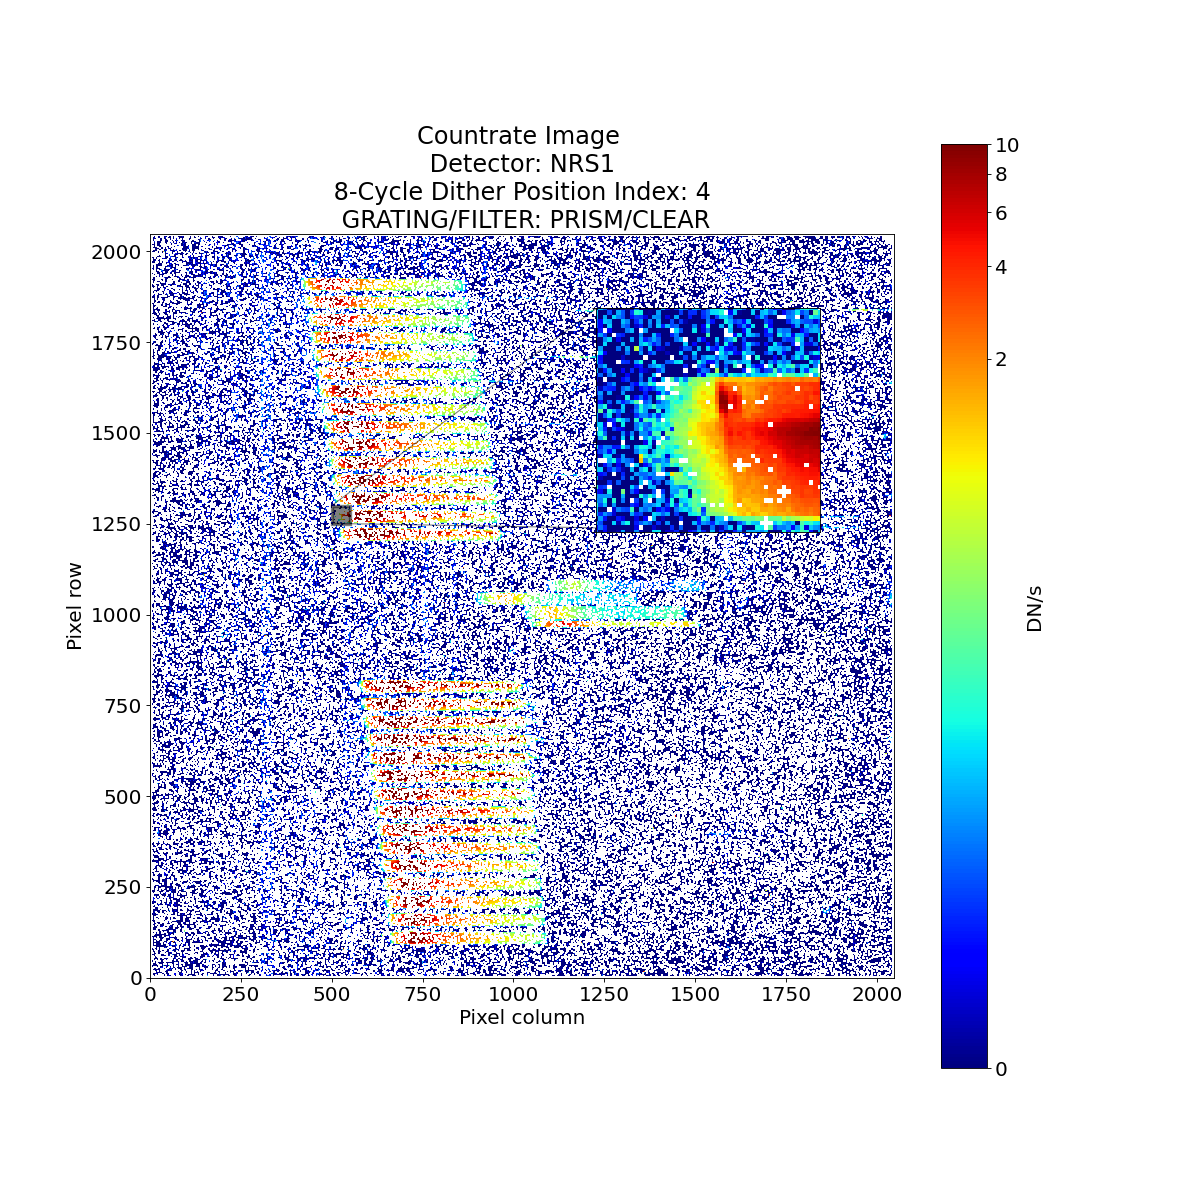

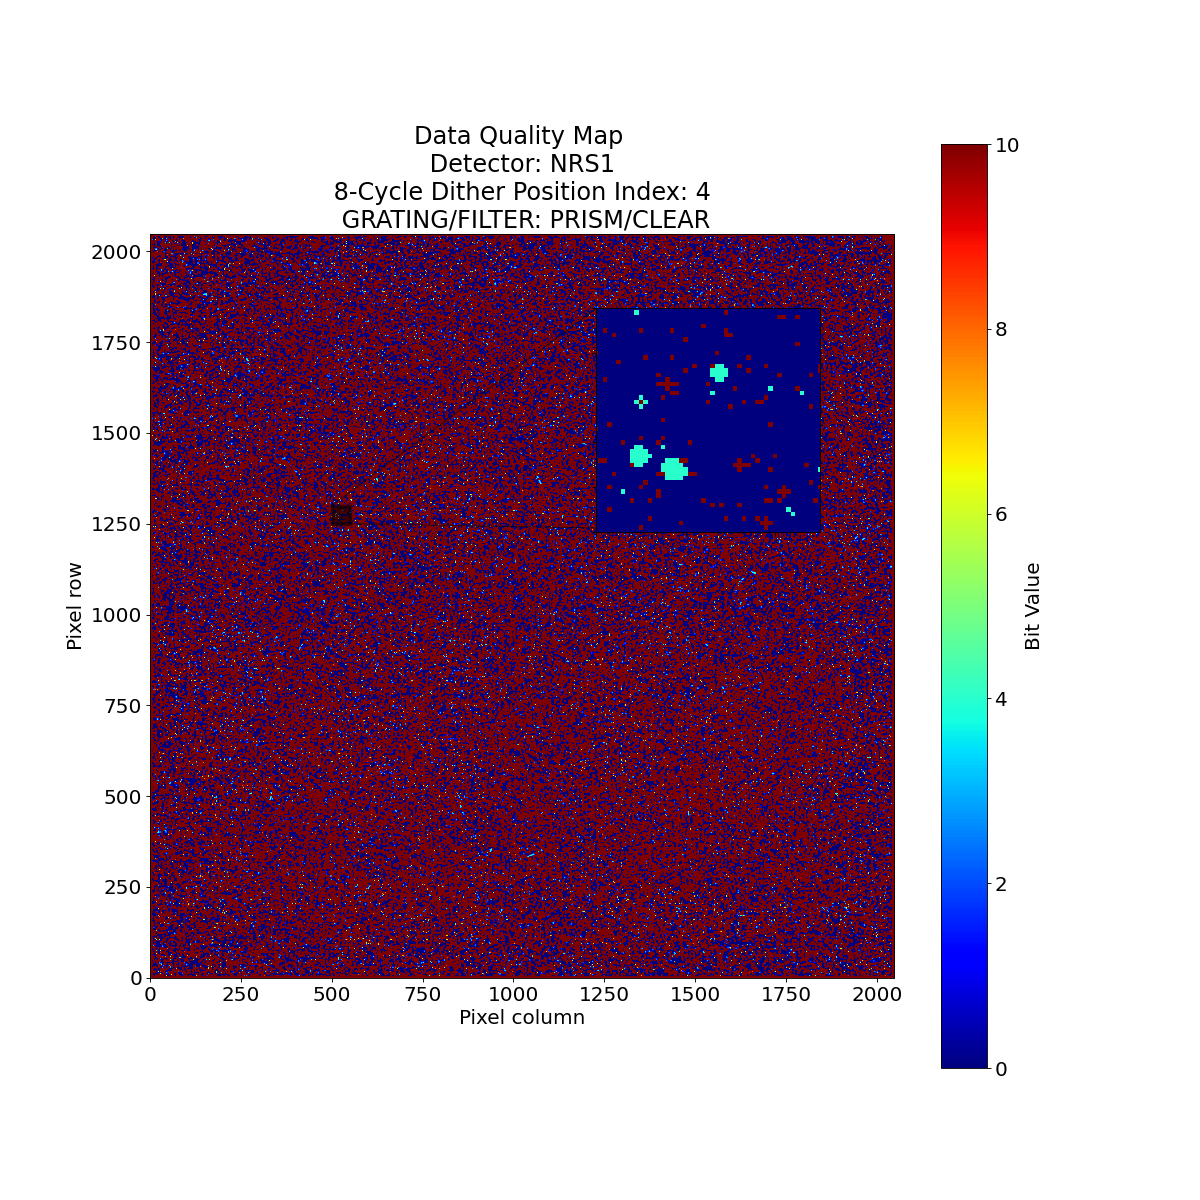

In [6]:
#Stage 1 slope products -- level 2a images

#Plot 4th (out of 8) dither position (spectra fall only on NRS1) for GRATING/FILTER PRISM/CLEAR combination  
for rate_file in sorted(glob.glob(mast_products_dir+'*00004_nrs1_rate.fits')):
    
    ratefile_open = datamodels.open(rate_file)
    ratefile_sci = ratefile_open.data #get the pixel data (the SCI extension of the fits file)
    ratefile_dq = ratefile_open.dq #data quality map data (DQ extension)
    
    #print the version and CRDS pmap used to create these rate.fits files 
    #ratefile_open.serach(key='context')
    print("Products found in MAST used JWST calibration pipeline version: {} and {}".format(ratefile_open.meta.calibration_software_version,
                                                                                            ratefile_open.meta.ref_file.crds.context_used))
    
    #Plot the slope image and zoom in on a small section of the countrate image & corresponding section of the DQ map
    show_image(ratefile_sci, 0,10, units='DN/s',zoom_in=[500,550, 1250,1300],
               title='Countrate Image \n Detector: {} \n 8-Cycle Dither Position Index: {} \n GRATING/FILTER: {}/{}'.format(ratefile_open.meta.instrument.detector,
                                                                                                                            ratefile_open.meta.dither.position_number, 
                                                                                                                            ratefile_open.meta.instrument.grating,
                                                                                                                            ratefile_open.meta.instrument.filter)) #rate files have units of DN/s
     
    show_image(ratefile_dq, 0, 10, units='Bit Value', scale='linear',zoom_in=[500,550, 1250,1300],
               title='Data Quality Map \n Detector: {} \n 8-Cycle Dither Position Index: {} \n GRATING/FILTER: {}/{}'.format(ratefile_open.meta.instrument.detector,
                                                                                                                            ratefile_open.meta.dither.position_number, 
                                                                                                                            ratefile_open.meta.instrument.grating,
                                                                                                                            ratefile_open.meta.instrument.filter)) 
             

<div class="alert alert-block alert-danger">
    
<b>Warning:</b> Please be aware that in the countrate (slope) images found in MAST, many pixels are flagged as Do Not Use (more clearly seen in the corresponding DQ map) and therefore appear white with a value of NaN. This excessive flagging is due to an outdated mask reference file that would mark unreliable slope, bad fit, and telegraph pixels as Do Not Use. Despite the large number of NaNs in the countrate image, the extracted spectra are not significantly affected by them when combining multiple dithered exposures because the number of flagged pixels is still a relatively small fraction. However, due to the high number of flags in the MAST products, it is difficult to see specific details in the slope images, like correlated read noise, which manifests as low-level vertical banding/striping and a "picture frame" with the [$IRS^{2}$](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-readout-modes-and-patterns/nirspec-irs2-detector-readout-mode) readout mode. As of context jwst_1084.pmap, the pipeline now considers unreliable slope, bad fit, and telegraph pixels good for further processing in Full frame data. [Therefore, the reprocessed data below offers improved visibility of the correlated read noise.](#level1_rerun)

</div>

### 6.2 Stage 2 Products Found In MAST  <a id='level2_mast'></a>
<hr style="border:1px solid gray">

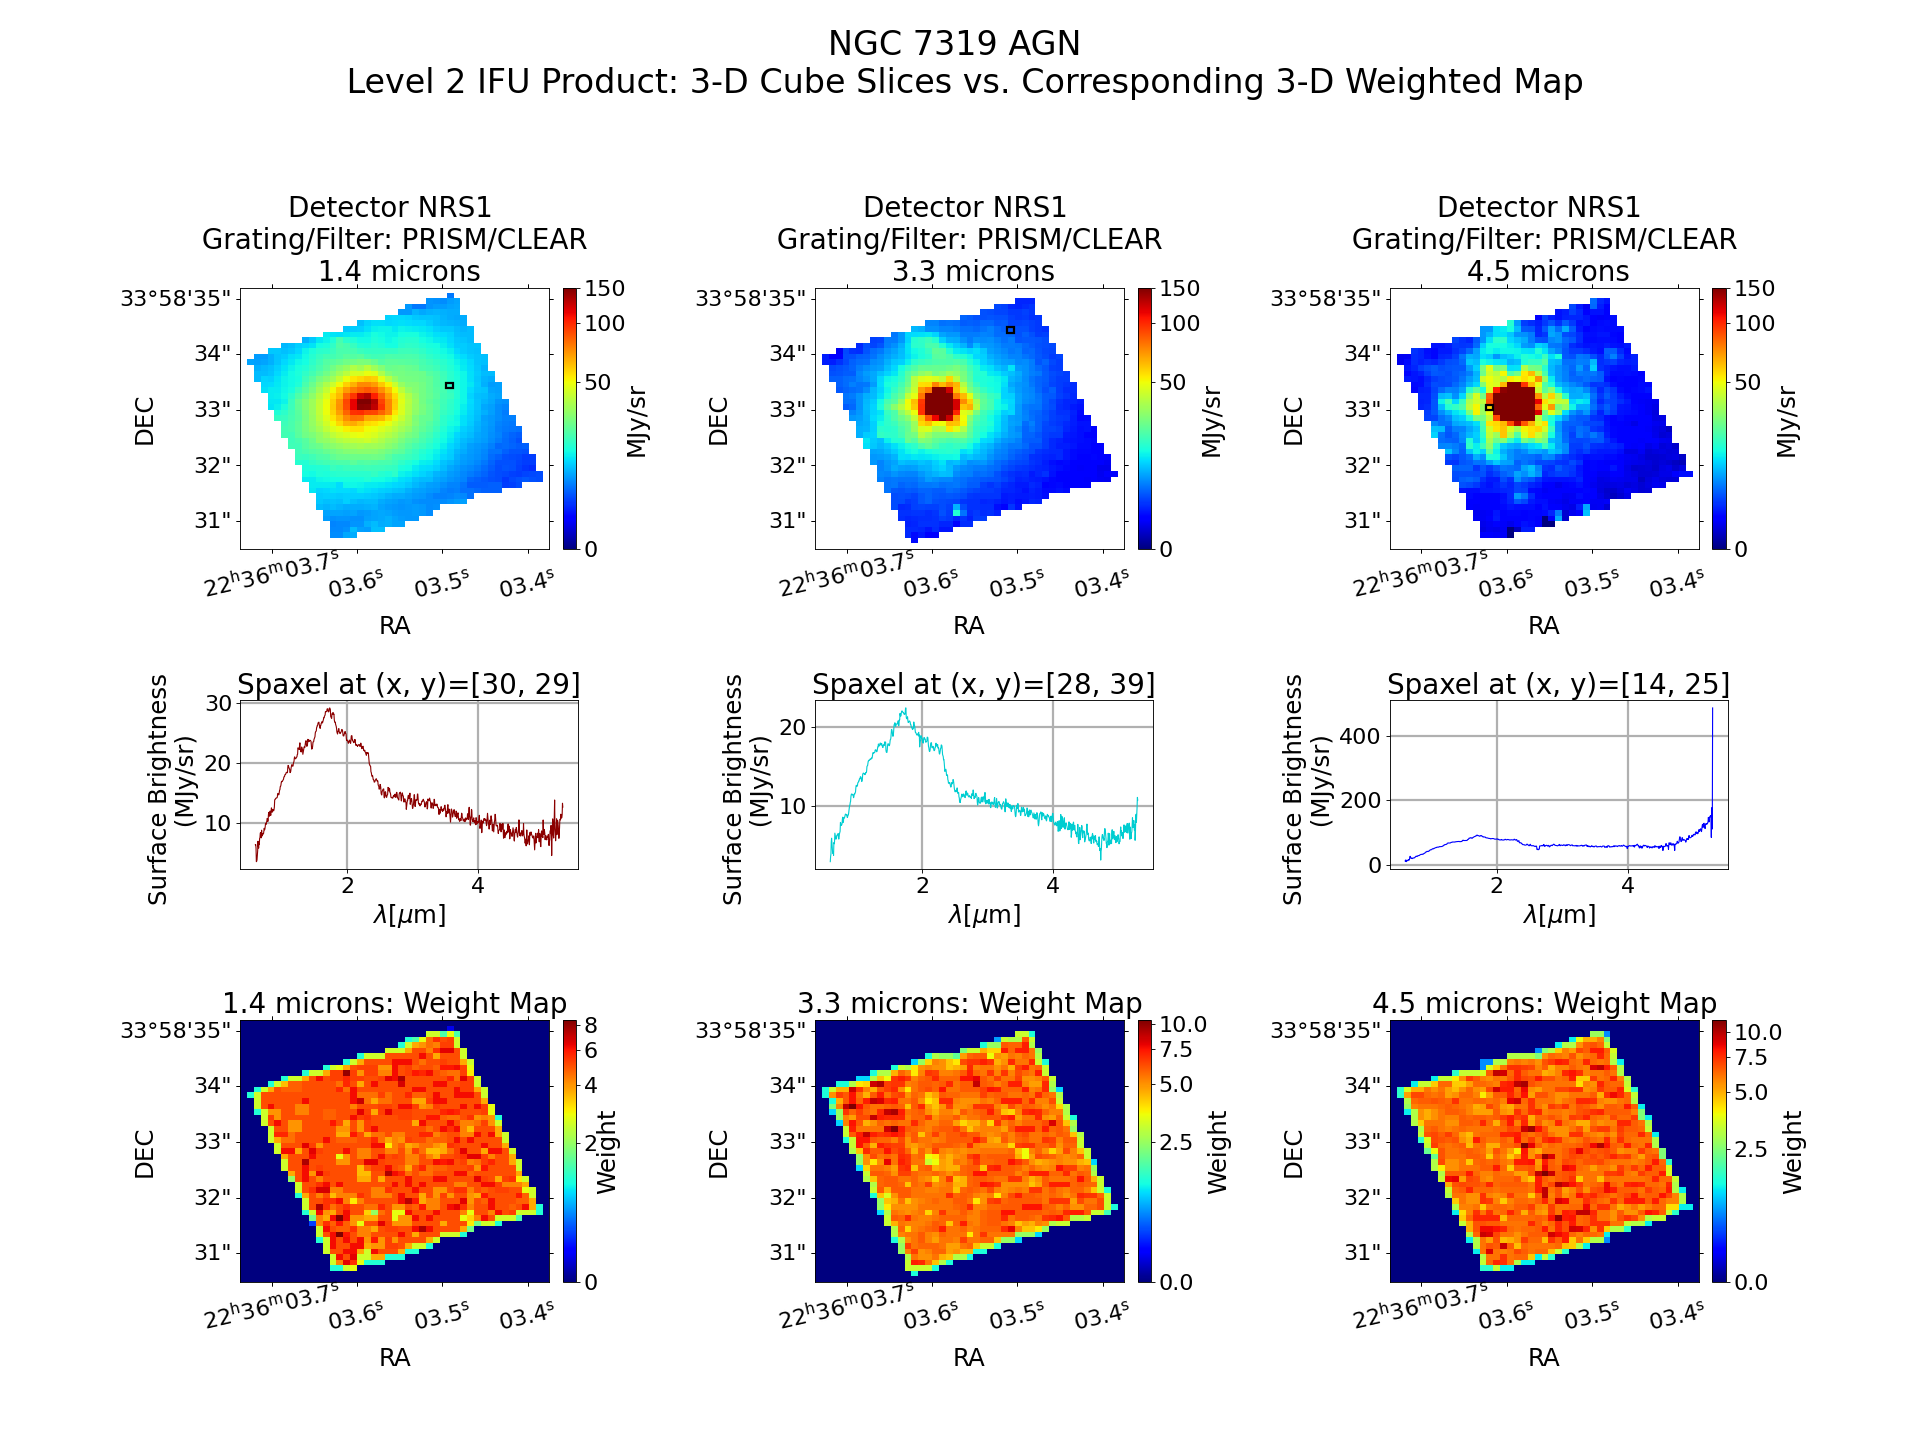

In [7]:
#Stage 2 Products -- Calibrated 3-D data cube for PRISM/CLEAR (only falls on NRS1)

#Plotting the 4th (out of 8) dither position
stage2_s3d_file = sorted(glob.glob(mast_products_dir+'*00004_nrs1_s3d.fits')) 

title_stage2_mast='NGC 7319 AGN \n Level 2 IFU Product: 3-D Cube Slices vs. Corresponding 3-D Weighted Map'


#Characteristics of the plot 
nrs1_wavelengths = [1.4,3.3,4.5] #Wavelength slices (microns) to take from the 3-D data cube
nrs1_spaxel_locs = [[30,29],[28,39],[14,25]] #Spaxel locations for associated 1-D spectrum (one spaxel plotted per slice)


#Plot using the convience function defined above
show_ifu_cubeslices(stage2_s3d_file, wavelength_slices=[nrs1_wavelengths], spaxel_locs=[nrs1_spaxel_locs],title=title_stage2_mast)

### 6.3 Stage 3 Products Found In MAST  <a id='level3_mast'></a>

<hr style="border:1px solid gray">

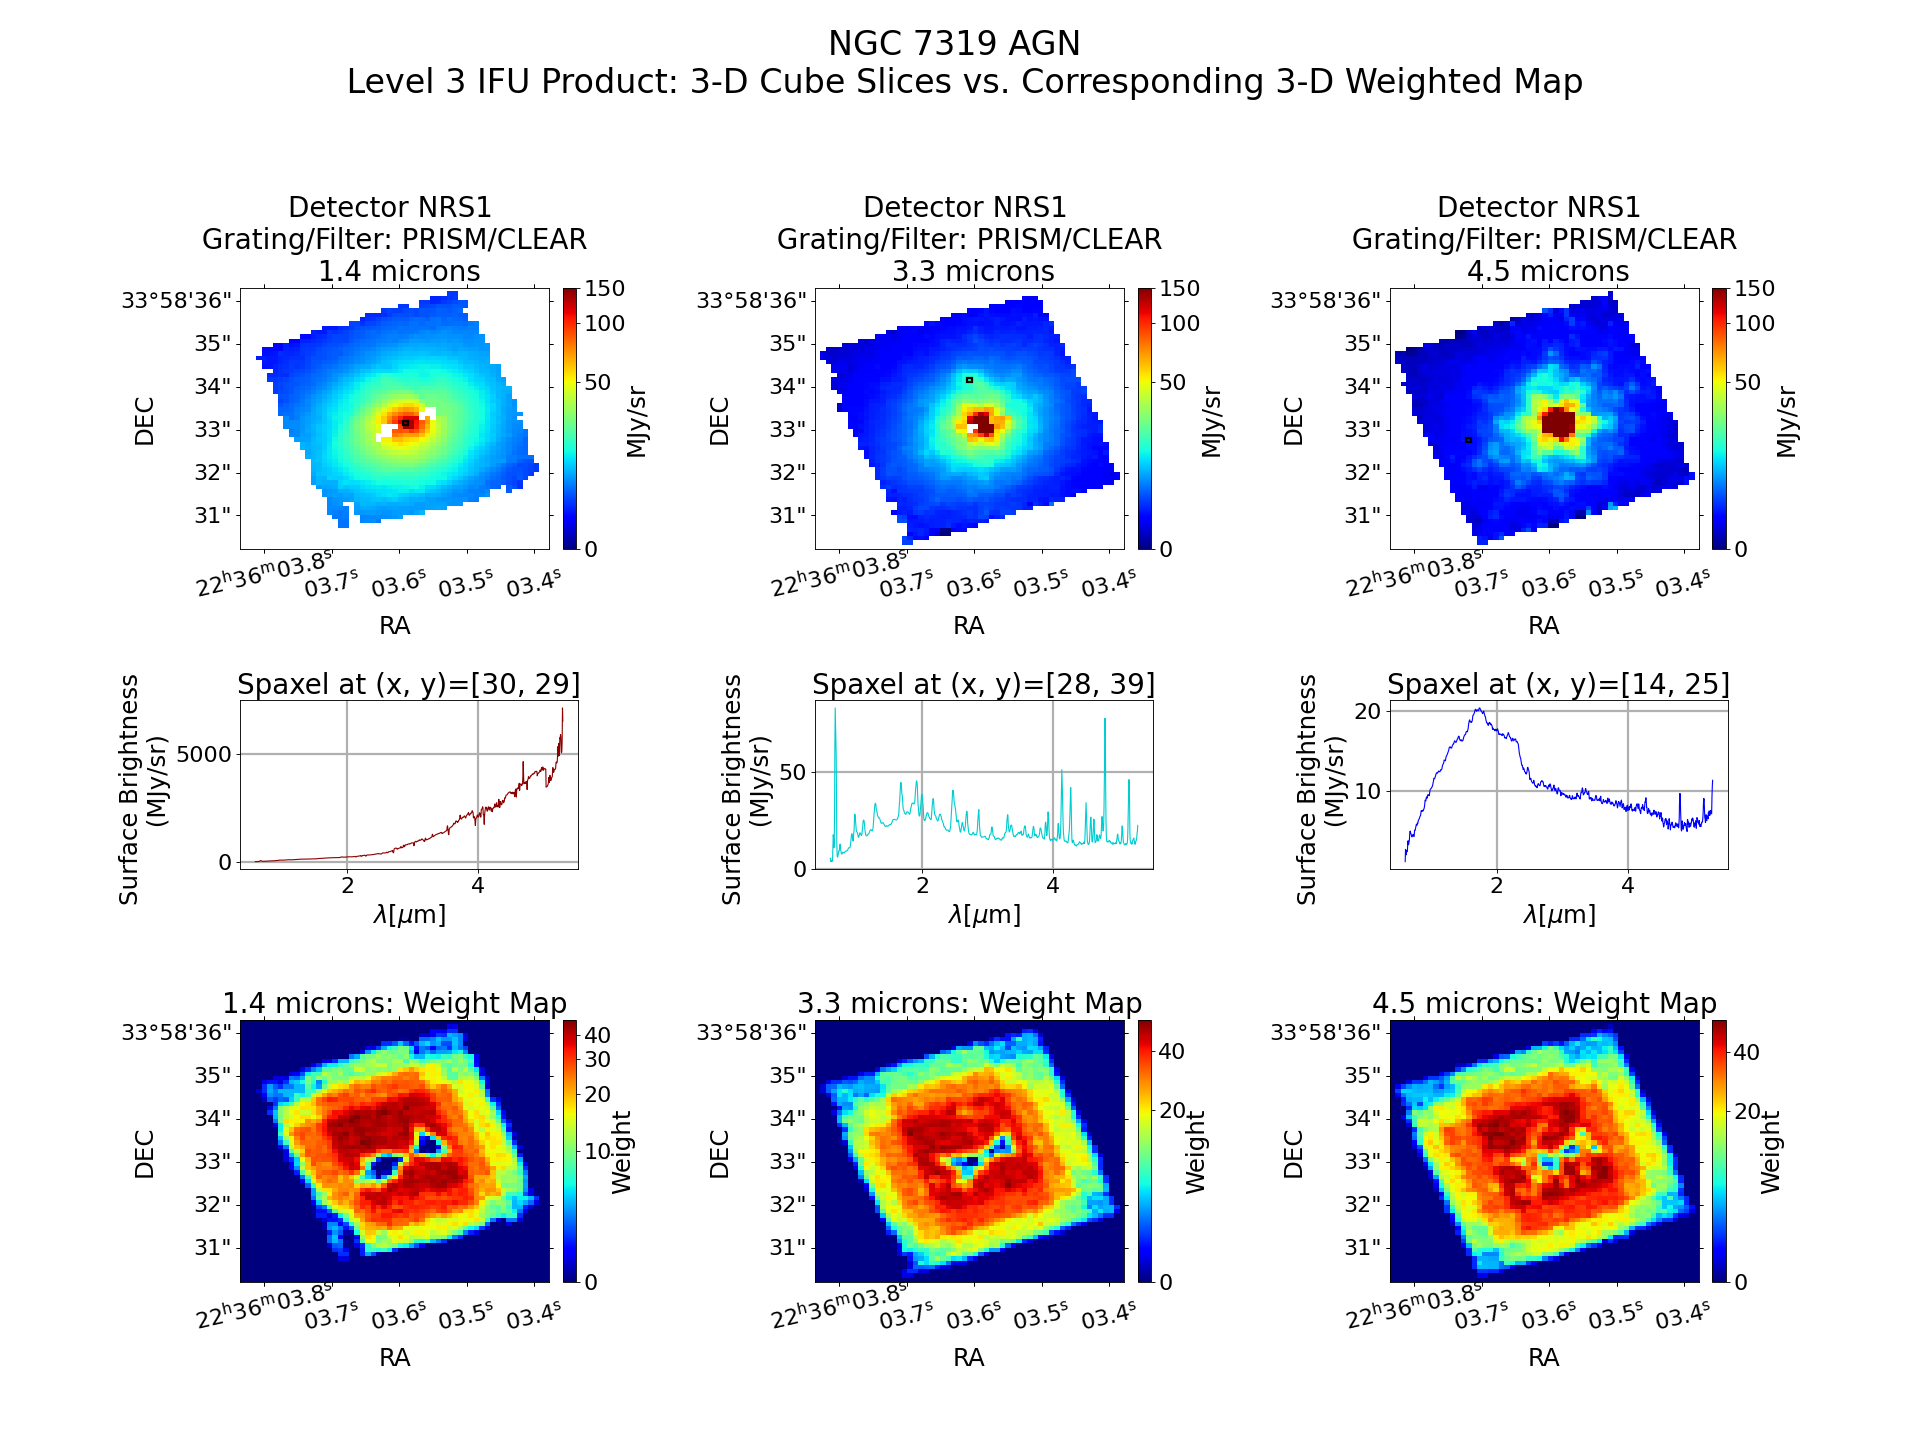

In [8]:
#Stage 3 Products -- Combined Calibrated 3-D data cube for PRISM/CLEAR (only falls on NRS1)

stage3_s3d_file = sorted(glob.glob(mast_products_dir+'*nirspec_prism-clear_s3d.fits')) 

title_stage3_mast='NGC 7319 AGN \n Level 3 IFU Product: 3-D Cube Slices vs. Corresponding 3-D Weighted Map'

#Characteristics of the plot 
nrs1_wavelengths = [1.4,3.3,4.5] #Wavelength slices (microns) to take from the 3-D data cube
nrs1_spaxel_locs = [[30,29],[28,39],[14,25]] #Spaxel locations for associated 1-D spectrum (one spaxel plotted per slice)

#Plot using the convience function defined above
show_ifu_cubeslices(stage3_s3d_file, wavelength_slices=[nrs1_wavelengths], spaxel_locs=[nrs1_spaxel_locs],title=title_stage3_mast)

<div class="alert alert-block alert-danger">
    
<b>Warning:</b> Please note that in the final product (stage 3) downloaded from MAST, a significant portion of the data got rejected, returning a value of zero in the weight maps. This over-rejection of data is due to the outdated `outlier_detection` step that MAST automatically enables during stage 3 of the pipeline. A new outlier detection algorithm has been developed specifically for IFU data that overcomes some of these limitations (as of DMS build B9.3rc1/CAL_VER 1.11.0). Due to the limitations of the previous outlier detection algorithm, the user recommendation is to skip the `outlier_detection` step if using an older version of the pipleine or manually rerun stage 3 of the pipleine with outlier detection on with the most up-to-date pipeline version (detailed in the next section of this notebook).
</div>

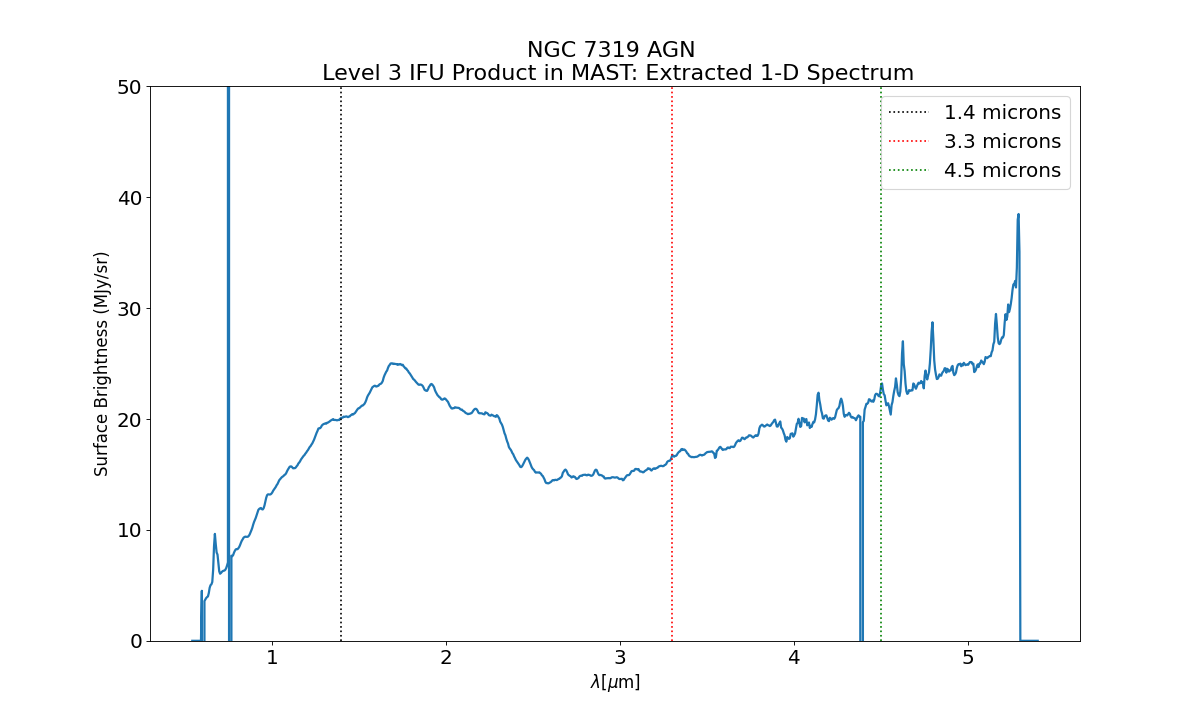

In [9]:
#Stage 3 Products -- Combined Extracted 1-D Spectrum 

x1d3_mast = datamodels.open(glob.glob(mast_products_dir+'*nirspec_prism-clear_x1d.fits')[0])

#Wavelength & Surface Brightness Arrays
x1d3wave_mast = x1d3_mast.spec[0].spec_table.WAVELENGTH
x1d3flux_mast = x1d3_mast.spec[0].spec_table.SURF_BRIGHT

#Plot the Extracted 1-D Spectrum
fig = plt.figure(figsize=(15,9))

plt.plot(x1d3wave_mast,x1d3flux_mast, linewidth =2)

#Where wavelength slice was taken above
plt.vlines(1.4, 0., 400., 'black', 'dotted', label='1.4 microns')
plt.vlines(3.3, 0., 400., 'red', 'dotted', label='3.3 microns')
plt.vlines(4.5, 0., 400., 'green', 'dotted', label='4.5 microns')

plt.xlabel('$\lambda [\mu$m]', fontsize =15)
plt.ylabel('Surface Brightness (MJy/sr)', fontsize =15)
plt.title("NGC 7319 AGN \n Level 3 IFU Product in MAST: Extracted 1-D Spectrum", fontsize =20)
plt.ylim(0, 50)
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
<b>Note:</b> When the source type is extended, the default extraction aperture for the `extract_1d` step covers the entire cube.

</div>

<div class="alert alert-block alert-danger">
<b>Warning:</b> Most of the large negative and positive flux spikes extending beyond the plot range are likely due to bad/hot pixels that are not flagged in the current DQ masks. The mask reference file gets directly pulled from CRDS. The products found in MAST use a specific CRDS context (.pmap) when processing data. However, the CRDS is constantly updating the operational .pmap.
</div>

In [10]:
#Just a check to see what verison of the pipeline and what pmap was used
x1d3_mast = fits.open(glob.glob(mast_products_dir+'*nirspec_prism-clear_x1d.fits')[0])

print("Products found in MAST used JWST calibration pipeline version: {} and {}".format(x1d3_mast[0].header['CAL_VER']
,x1d3_mast[0].header['CRDS_CTX']))

Products found in MAST used JWST calibration pipeline version: 1.9.6 and jwst_1075.pmap


### 7. Re-processing the Data <a id='reprocessing'></a>
<hr style="border:1px solid gray">

In [11]:
#Directory for rerun of stage 1 to avoid overwritting MAST products
output_dir_rerun = output_dir+'rerun/' 
if not os.path.exists(output_dir_rerun):
    os.makedirs(output_dir_rerun)

### 7.1 Stage 1 Rerun & Products  <a id='level1_rerun'></a>
<hr style="border:1px solid gray">

In [12]:
#Stage 1 Processing 

if runflag == True:

    for uncal_file in sorted(glob.glob(mast_products_dir+'*nrs1_uncal.fits')): 

        print("Applying Stage 1 Corrections & Calibrations to: "+ os.path.basename(uncal_file))

        result = Detector1Pipeline.call(uncal_file,
                                        save_results = True,
                                        output_dir = output_dir_rerun)

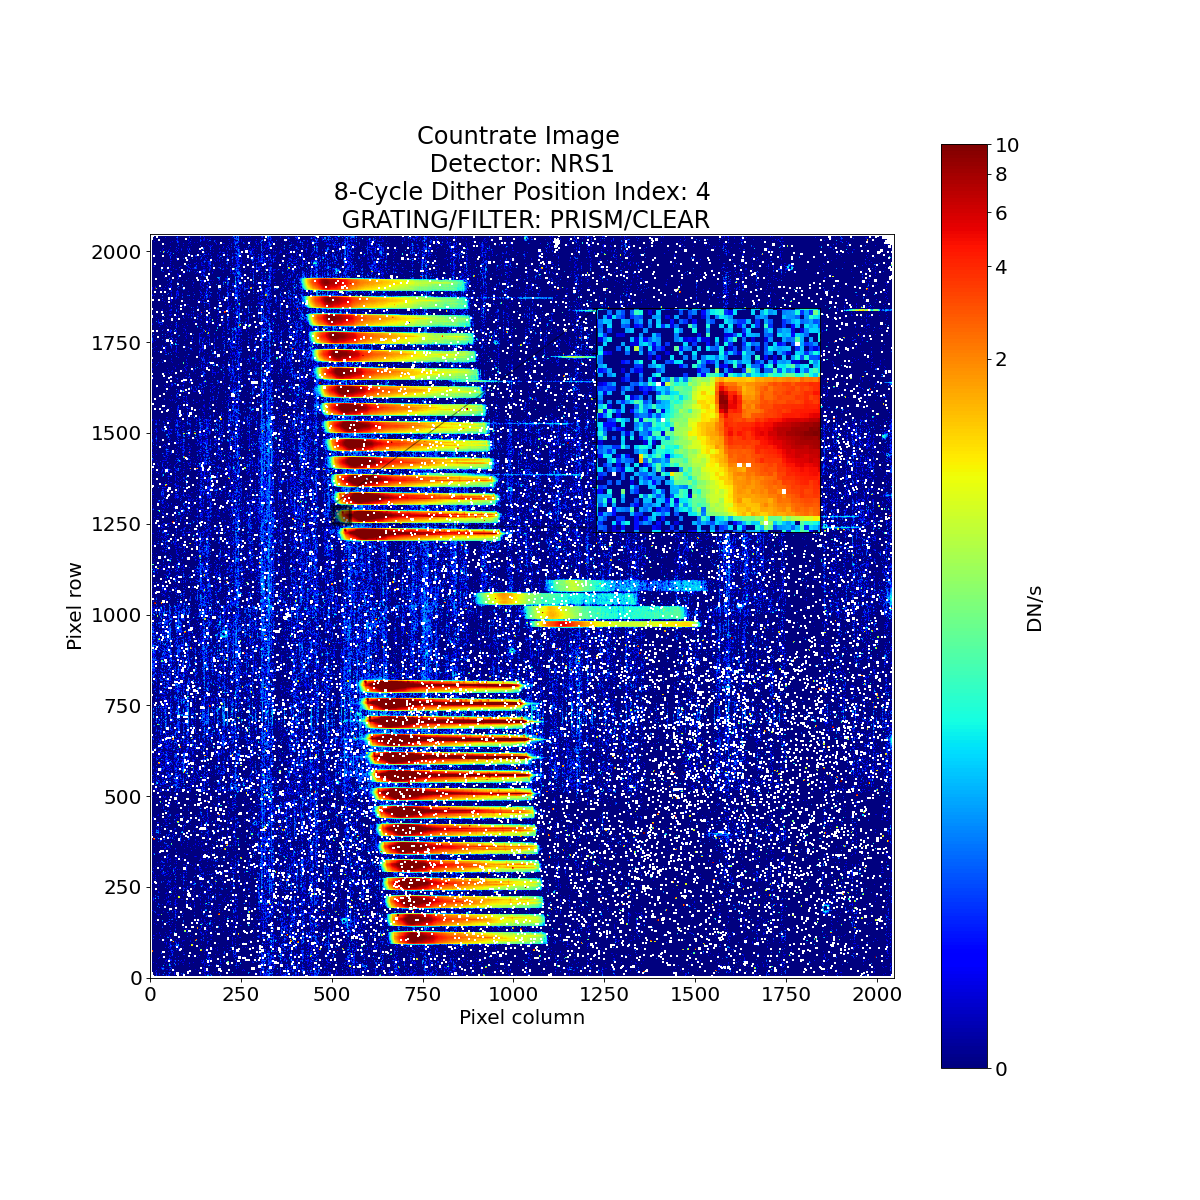

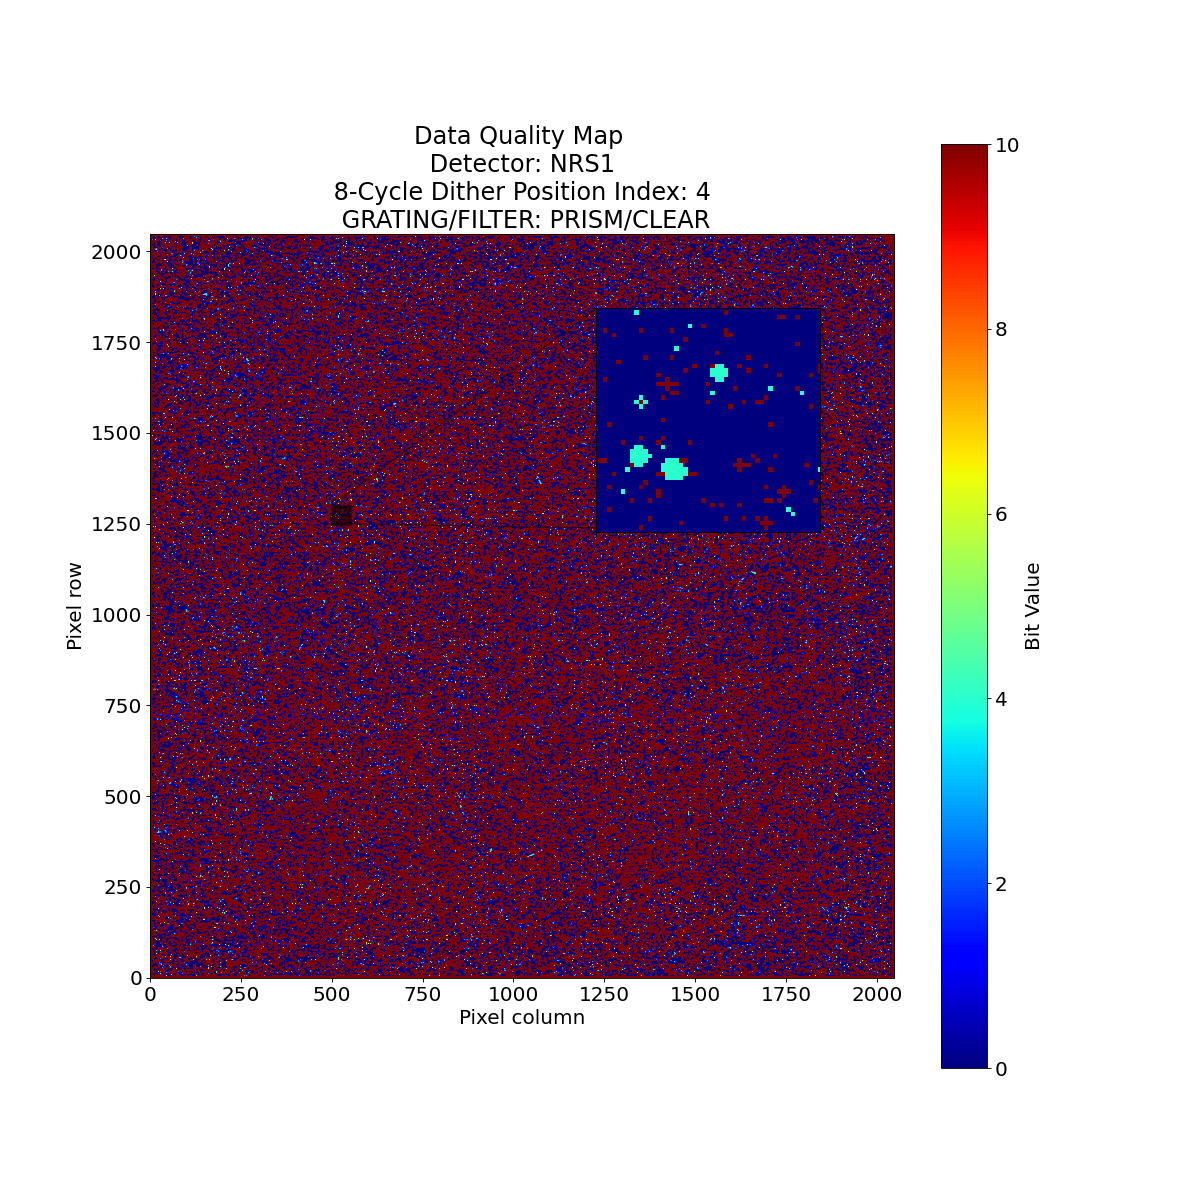

In [13]:
#Stage 1 slope products -- level 2a images

#Plot 4th (out of 8) dither position (NRS1 & NRS2) for GRATING/FILTER G140H/F100LP combination  
for rate_file in sorted(glob.glob(output_dir_rerun+'*00004_nrs?_rate.fits')):
    
    ratefile_open = datamodels.open(rate_file)
    ratefile_sci = ratefile_open.data # Get the pixel data (the SCI extension of the fits file)
    ratefile_dq = ratefile_open.dq # The Data Quality Map Data
    
    
    show_image(ratefile_sci, 0,10, units='DN/s',zoom_in=[500,550, 1250,1300],
               title='Countrate Image \n Detector: {} \n 8-Cycle Dither Position Index: {} \n GRATING/FILTER: {}/{}'.format(ratefile_open.meta.instrument.detector,
                                                                                                                            ratefile_open.meta.dither.position_number, 
                                                                                                                            ratefile_open.meta.instrument.grating,
                                                                                                                            ratefile_open.meta.instrument.filter)) #rate files have units of DN/s
    
    show_image(ratefile_dq, 0, 10, units='Bit Value', scale='linear',zoom_in=[500,550, 1250,1300],
               title='Data Quality Map \n Detector: {} \n 8-Cycle Dither Position Index: {} \n GRATING/FILTER: {}/{}'.format(ratefile_open.meta.instrument.detector,
                                                                                                                             ratefile_open.meta.dither.position_number, 
                                                                                                                             ratefile_open.meta.instrument.grating,
                                                                                                                             ratefile_open.meta.instrument.filter)) #rate files have units of DN/s
    
       
             

<div class="alert alert-block alert-info">
    
<b>Note:</b> Compared to the [countrate (slope) products found in MAST](#level1_mast), fewer pixels are flagged as Do Not Use when using the most up-to-date pmap in CRDS (at the time jwst_1106.pmap). With the latest pmap, one can observe low-level vertical banding in the central regions of the detector, and the "picture frame" towards the edge of both detectors, where there is less correlated read noise a lot easier. 
</div>

### 7.2 Stage 2 Rerun & Products  <a id='level2_rerun'></a>
<hr style="border:1px solid gray">

During stage 2 of the pipeline, the countrate (slope) image products from stage 1, which have units of DN/s, are converted to units of surface brightness (MJy/sr) for both extended and point sources (as of DMS build 9.3/CAL_VER 1.10.2). For extended targets, like the NGC 7319 AGN, the `extract_1d` step is controlled by a different set of parameters in the EXTRACT1D reference file: 

> For an extended source, rectangular aperture photometry is used, with the entire image being extracted, and no background subtraction, regardless of what was specified in the reference file or step arguments. [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)

<div class="alert alert-block alert-warning">
    
<b>Warning:</b> Note there has been a bug in the `cube_build` step that caused the point source flux to not be conserved when using different spatial sampling. A fix has been implemented as of release DMS build 9.3/CAL_VER 1.10.2. In order to enable the correct functionality, the units of the cal.fits files and cubes will now be in surface brightness, and only the 1-D extracted spectra will be in units of Jy.
</div>

In [14]:
#Stage 2 Processing 

if runflag == True:
    
    #Process each rate file seperately 
    for rate_file in sorted(glob.glob(output_dir_rerun+'*nrs1*rate.fits')):
            
        print("Applying Stage 2 Calibrations & Corrections to: "+ os.path.basename(rate_file))

        result = Spec2Pipeline.call(rate_file,
                                    save_results = True,
                                    output_dir = output_dir_rerun)

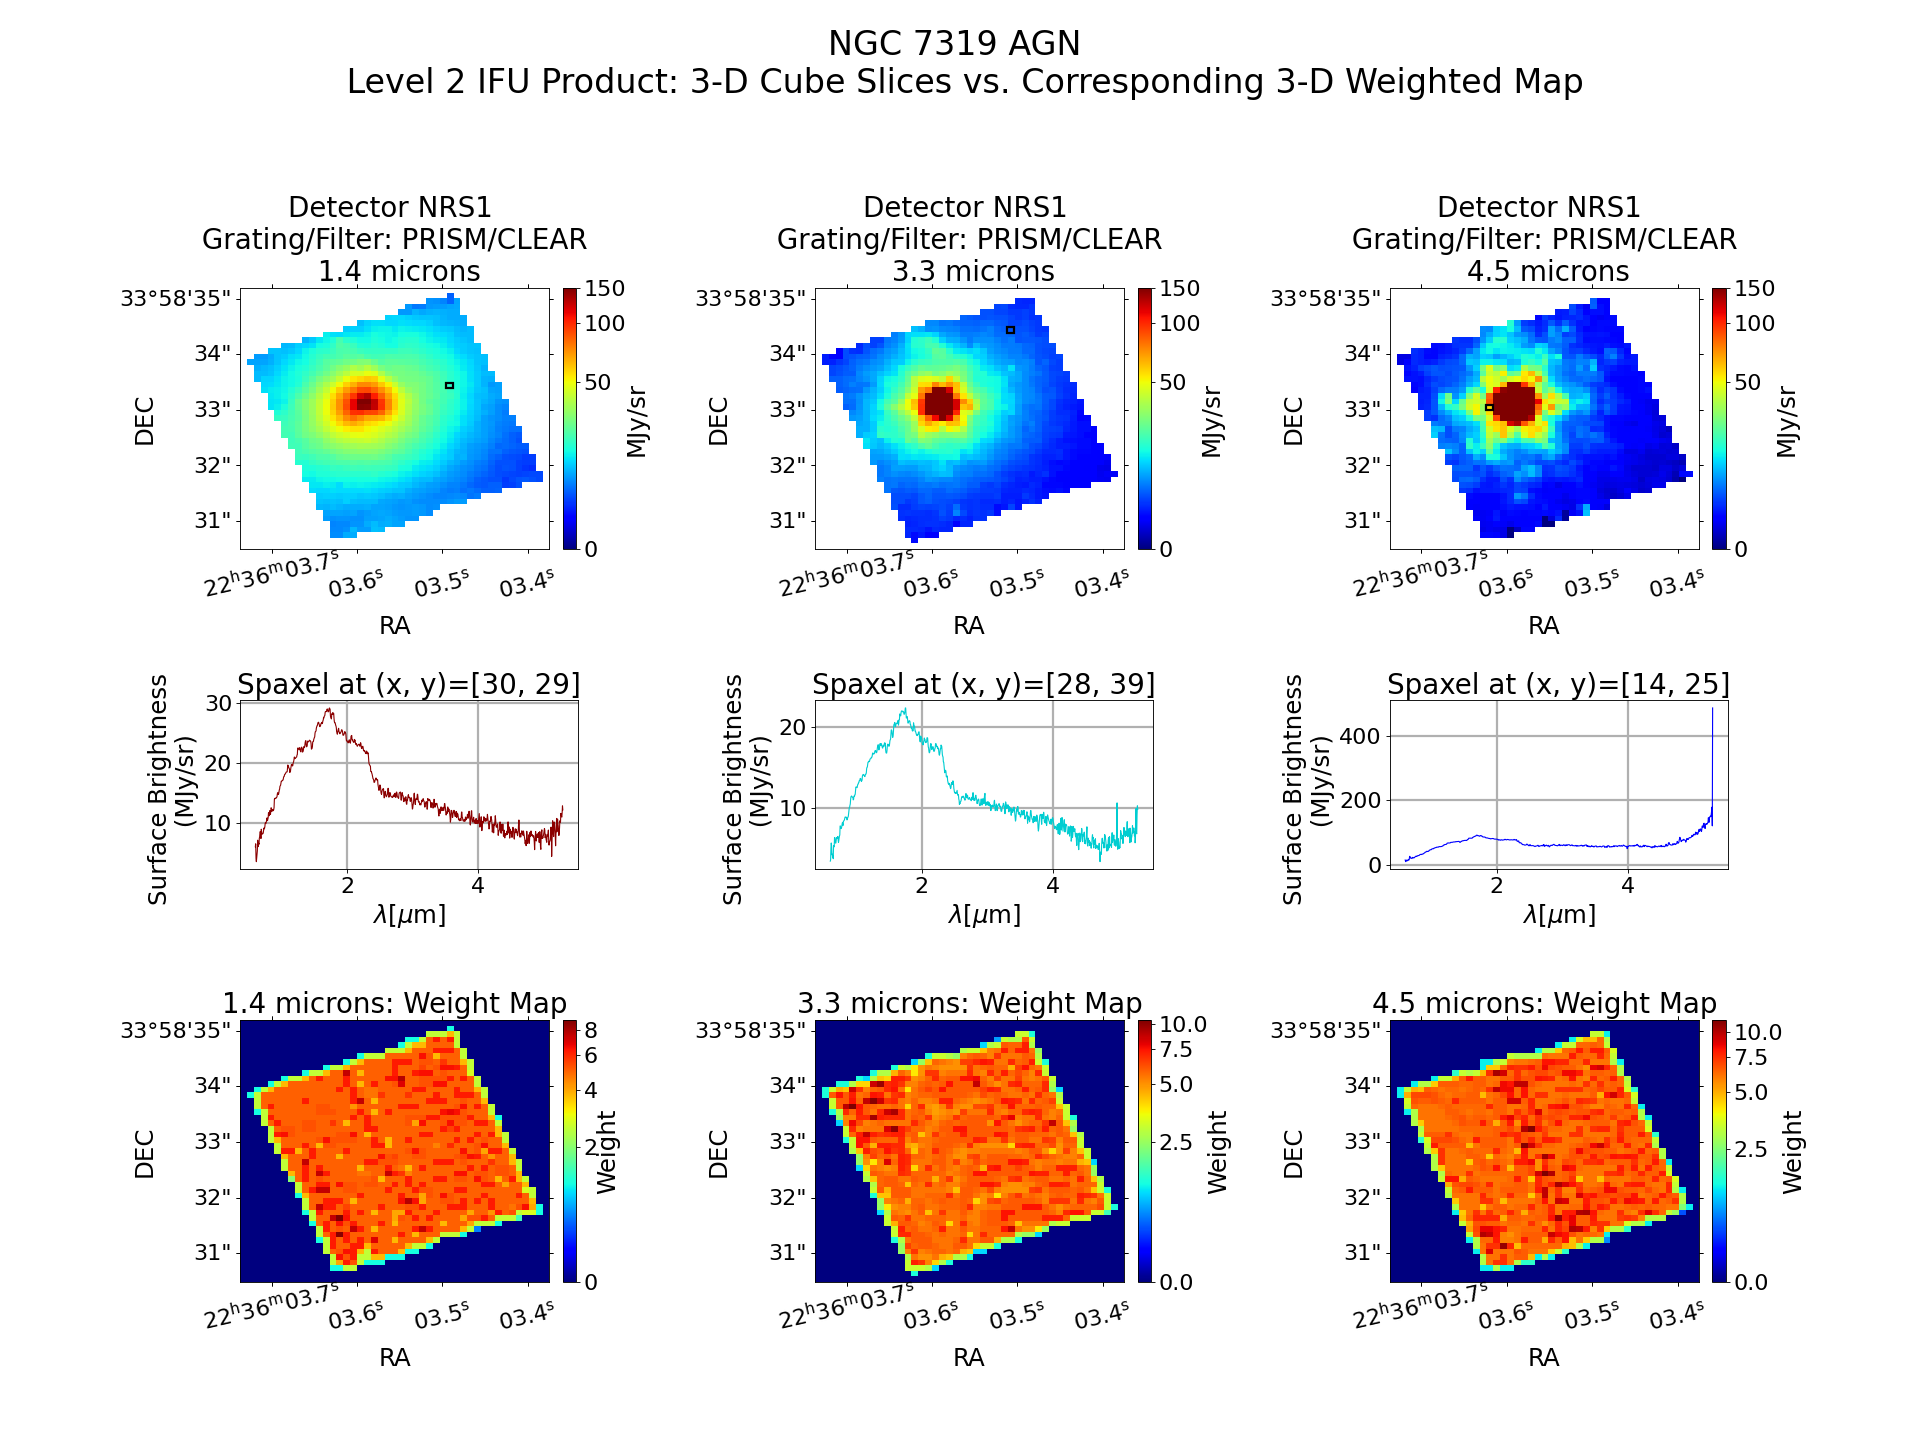

In [15]:
#Stage 2 Products -- Calibrated 3-D data cube for PRISM/CLEAR (only falls on NRS1)

#Plotting the 4th (out of 8) dither position
stage2_s3d_file = sorted(glob.glob(output_dir_rerun+'*00004_nrs1_s3d.fits')) 

title_stage2_rerun='NGC 7319 AGN \n Level 2 IFU Product: 3-D Cube Slices vs. Corresponding 3-D Weighted Map'


#Characteristics of the plot 
nrs1_wavelengths = [1.4,3.3,4.5] #Wavelength slices (microns) to take from the 3-D data cube
nrs1_spaxel_locs = [[30,29],[28,39],[14,25]] #Spaxel locations for associated 1-D spectrum (one spaxel plotted per slice)


#Plot using the convience function defined above
show_ifu_cubeslices(stage2_s3d_file, wavelength_slices=[nrs1_wavelengths], spaxel_locs=[nrs1_spaxel_locs],title=title_stage2_rerun)

### 7.3 Stage 3 Rerun & Products  <a id='level3_rerun'></a>
<hr style="border:1px solid gray">

***Level 3 ASN File***

> Observations that use a nod-type/dither patterns, their exposures are related. [Association files (ASN)](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) describe how multiple exposures are related to one another and how they depend on one another. Processing an ASN file permits exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than individual objects. IFU exposures taken with a dither pattern are not used for pixel-to-pixel background subtraction by the calibration pipeline (unlike exposures taken with a nod pattern).

Therefore, all calibration files (`cal.fits`) in our spec3 ASN file should be labeled as science exposures (`exptype: science`).  

In [16]:
#Copy ASN file from MAST into the stage 1 rerun directory

asnfile_mast = glob.glob(mast_products_dir+'*_spec3_00001_asn.json')[0] #ASN file found in MAST

asnfile_rerun = output_dir_rerun+os.path.basename(asnfile_mast) #New ASN file path
if not os.path.exists(asnfile_rerun):
    copy(asnfile_mast, asnfile_rerun)
    
#Check the ASN file contents
with open(asnfile_rerun, 'r') as f_obj:
    asnfile_rerun_data = json.load(f_obj)
        
asnfile_rerun_data

{'asn_type': 'spec3',
 'asn_rule': 'candidate_Asn_Lv3NRSIFU',
 'version_id': '20230401t123831',
 'code_version': '1.9.6',
 'degraded_status': 'No known degraded exposures in association.',
 'program': '02732',
 'constraints': 'DMSAttrConstraint({\'name\': \'program\', \'sources\': [\'program\'], \'value\': \'2732\'})\nDMSAttrConstraint({\'name\': \'instrument\', \'sources\': [\'instrume\'], \'value\': \'nirspec\'})\nConstraint_Target({\'name\': \'target\', \'sources\': [\'targetid\'], \'value\': \'2\'})\nDMSAttrConstraint({\'name\': \'exp_type\', \'sources\': [\'exp_type\'], \'value\': \'nrs_autowave|nrs_ifu\'})\nDMSAttrConstraint({\'name\': \'patttype\', \'sources\': [\'patttype\'], \'value\': \'cycling\'})\nDMSAttrConstraint({\'name\': \'opt_elem\', \'sources\': [\'grating\'], \'value\': \'prism\'})\nConstraint_Obsnum({\'name\': \'obs_num\', \'sources\': [\'obs_num\'], \'value\': None})\nConstraint_TargetAcq({\'name\': \'target_acq\', \'value\': \'target_acquisition\'})\nDMSAttrConst

#### 7.3.1 New Outlier Detection Algorithm<a id='outlier_detection_new'></a>
<hr style="border:1px solid gray">

The new outlier detection algorithm for IFU data (as of DMS build B9.3rc1/CAL_VER 1.11.0) implements the basic outlier detection algorithm -- searches for pixels that are consistent outliers in the calibrated images created by the `calwebb_spec2` pipeline. The algorithm generally operates as follows:

> * Identifies outlier pixels by comparing them with their neighboring pixels in the spatial direction across a set of input files within an association.
> * For NIRSpec data, it calculates differences between pixels located above and below each science pixel.
> * The pixel differences for every input model in the association are computed and stored in a stack of pixel differences.
> * For each pixel, the algorithm determines the minimum difference across this stack and then performs normalization. This normalization process employs a local median derived from the difference array, with the size of the median determined by the kernel size.
> * A pixel is flagged as an outlier if this normalized minimum difference is greater than the input threshold percentage. 
> * Pixels that are found to be outliers are flaged in in the DQ array.
> * [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/outlier_detection_ifu.html#outlier-detection-ifu)

**[The outlier_detection step for IFU data has the following optional arguments that control the behavior of the processing](https://github.com/spacetelescope/jwst/blob/master/docs/jwst/outlier_detection/arguments.rst):**

* `kernel_size` (string, default='7 7'): The size of the kernel to use to normalize the pixel differences. The kernel size must only contain odd values.
* `threshold_percent` (float, default=99.8): The threshold (in percent) of the normalized minimum pixel difference used to identify bad pixels. Pixels with a normalized minimum pixel difference above this percentage are flagged as a outlier.
* `save_intermediate_results` (boolean, default=False): Specifies whether or not to save any intermediate products created during step processing.


In [17]:
#Rerun stage 3 with outlier detection off
if runflag==True:

    result = Spec3Pipeline.call(asnfile_rerun,
                                save_results = True,
                                output_dir = output_dir_rerun,
                                steps = {"outlier_detection":{"skip": False,
                                                              "save_results": True,
                                                              "kernel_size": '3 3'}})

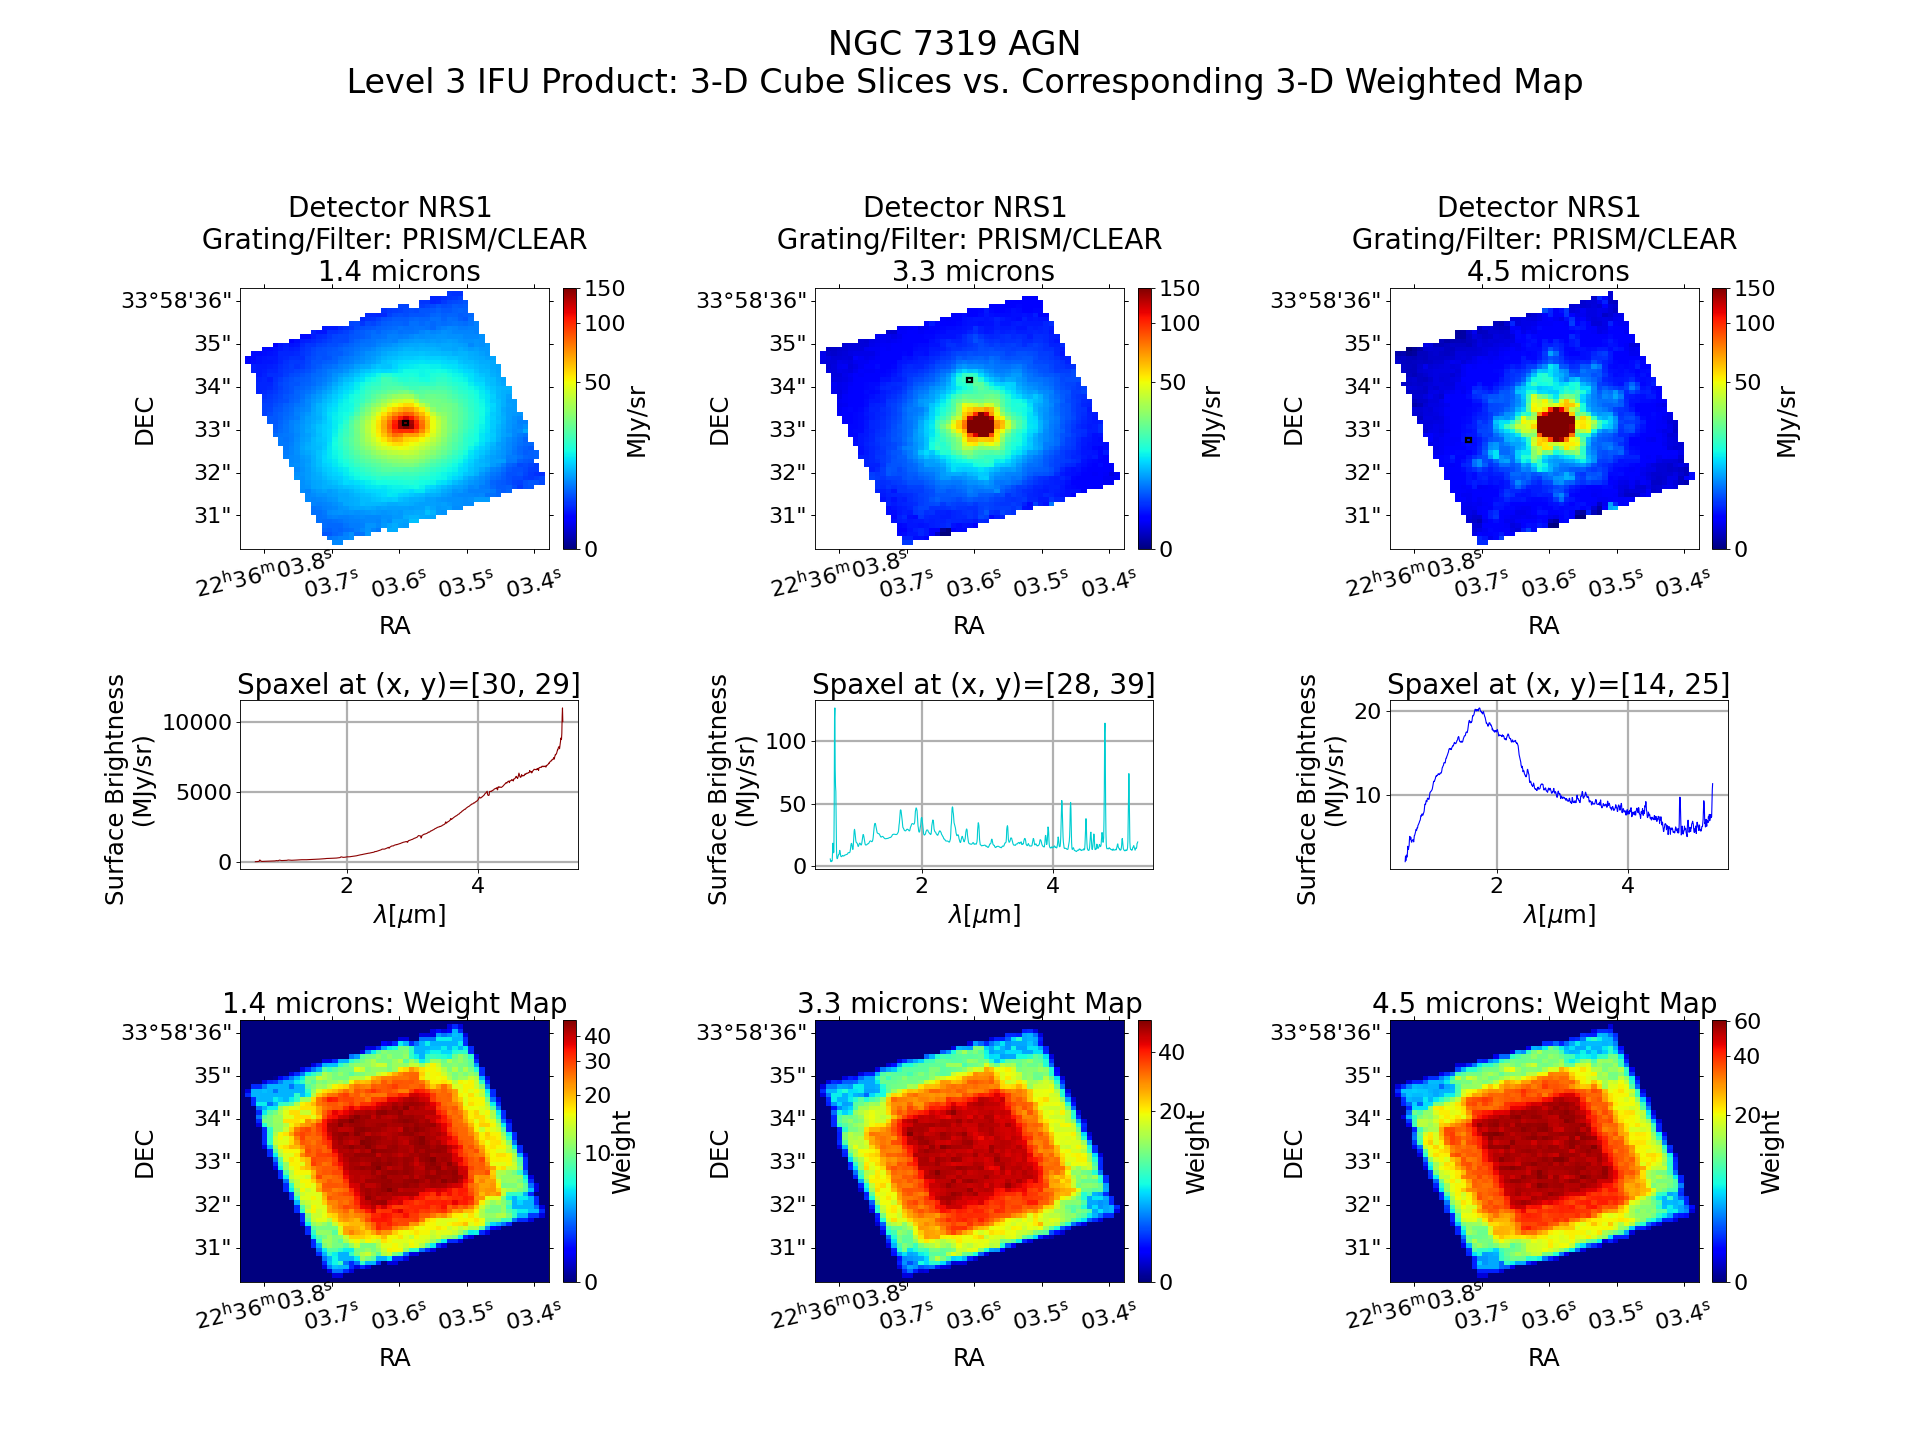

In [18]:
#Stage 3 Products -- Combined Calibrated 3-D data cube for PRISM/CLEAR 

stage3_s3d_file = sorted(glob.glob(output_dir_rerun+'*nirspec_prism-clear_s3d.fits')) 

title_stage3_rerun='NGC 7319 AGN \n Level 3 IFU Product: 3-D Cube Slices vs. Corresponding 3-D Weighted Map'

#Characteristics of the plot 
nrs1_wavelengths = [1.4,3.3,4.5] #Wavelength slices (microns) to take from the 3-D data cube
nrs1_spaxel_locs = [[30,29],[28,39],[14,25]] #Spaxel locations for associated 1-D spectrum (one spaxel plotted per slice)

#Plot using the convience function defined above
show_ifu_cubeslices(stage3_s3d_file, wavelength_slices=[nrs1_wavelengths], spaxel_locs=[nrs1_spaxel_locs],title=title_stage3_rerun)

<div class="alert alert-block alert-info">
    
<b>Note:</b> In comparison to the [weight maps for the 3-D data cube products found in MAST](#level3_mast), the implementation of the new outlier detection algorithm leads to a notable decrease data rejection.

</div>

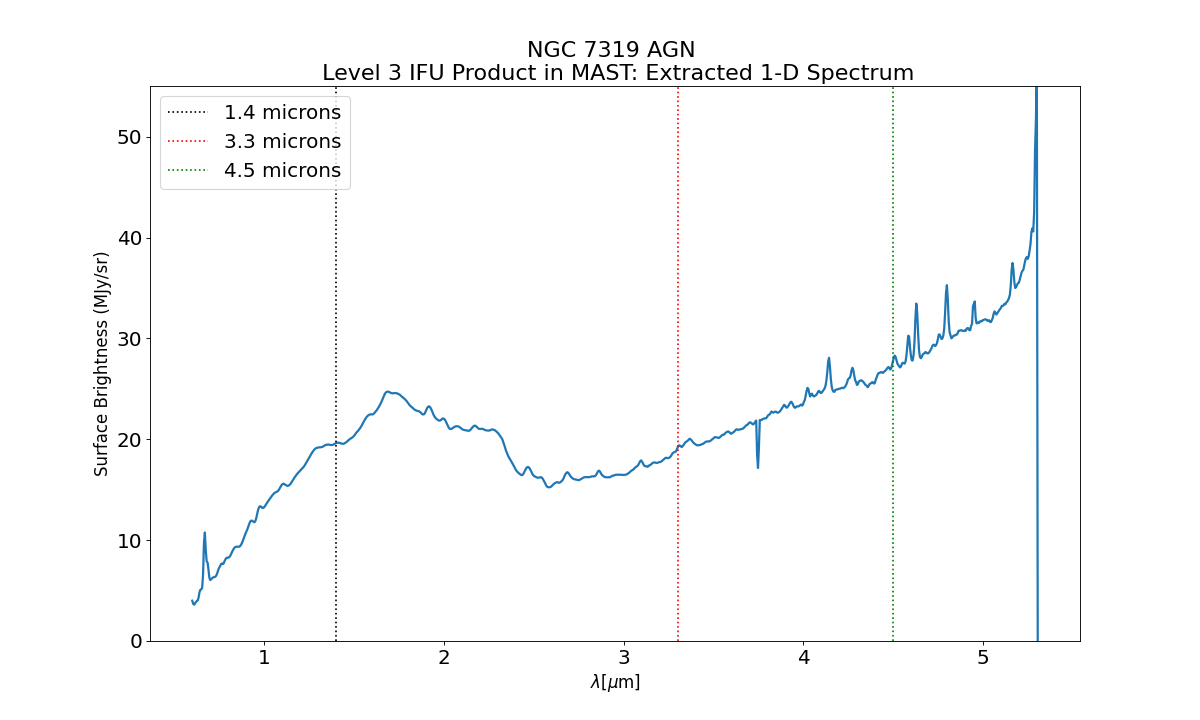

In [19]:
#Stage 3 Products -- Combined Extracted 1-D Spectrum 

x1d3_rerun = datamodels.open(glob.glob(output_dir_rerun+'*nirspec_prism-clear_x1d.fits')[0])

#Wavelength & Surface Brightness Arrays
x1d3wave_rerun = x1d3_rerun.spec[0].spec_table.WAVELENGTH
x1d3flux_rerun = x1d3_rerun.spec[0].spec_table.SURF_BRIGHT

#Plot the Extracted 1-D Spectrum
fig = plt.figure(figsize=(15,9))

plt.plot(x1d3wave_rerun,x1d3flux_rerun, linewidth =2)

#Where wavelength slice was taken above
plt.vlines(1.4, 0., 400., 'black', 'dotted', label='1.4 microns')
plt.vlines(3.3, 0., 400., 'red', 'dotted', label='3.3 microns')
plt.vlines(4.5, 0., 400., 'green', 'dotted', label='4.5 microns')

plt.xlabel('$\lambda [\mu$m]', fontsize =15)
plt.ylabel('Surface Brightness (MJy/sr)', fontsize =15)
plt.title("NGC 7319 AGN \n Level 3 IFU Product in MAST: Extracted 1-D Spectrum", fontsize =20)
plt.ylim(0, 55)
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
<b>Note:</b> With the integration of the new outlier detection algorithm, a significant change is evident when comparing to the [1-D extracted spectrum found in MAST](#level3_mast). Previously prominent positive/negative spikes in the data have now been successfully identified and flagged as outliers.  
</div>




## Conclusion <a id='conclusion'></a>
<hr style="border:1px solid gray">  

In conclusion, this notebook walks users through processing real data (NGC 7319 AGN) from ERS Proposal ID 2732 and comparing automated products in MAST with those generated using the latest version of the JWST calibration pipeline and latest CRDS context. For optimal results, users are strongly encouraged to reprocess their own data using the most recent pipeline version and CRDS context, taking advantage of bug fixes and algorithm improvements (i.e., the new IFU outlier detection algorithm). 

## About This Notebook <a id='about'></a>
<hr style="border:1px solid gray">  

**Authors**: Kayli Glidic (kglidic@stsci.edu),  Leonardo Ubeda (lubeda@stsci.edu)

**Update On**: 2023-08-11